# Задача 2. Линейная регрессия, метод градиентного спуска.

- [✓] Самостоятельно реализовать функцию **gradient_descent(X, y)**, которая по заданной обучающей выборке обучает модель линейной регрессии, оптимизируя функционал **методом градиентного спуска (Batch Gradient Descent, GD)** и возвращая вектор весов **w**. В качестве функционала можно выбрать, например, функцию ошибок **MSE** + $L_2$-регуляризатор. Использовать матрично-векторные операции для вычисления градиента.
- [✓] Найти данные, на которых интересно будет решать задачу регрессии. Зависимость целевого признака от нецелевых должна быть не слишком сложной, чтобы обученная линейная модель смогла показать приемлимый результат. В крайнем случае взять данные для предсказания стоимости машин [тут](https://github.com/rustam-azimov/ml-course-itmo/tree/main/data/car_price) (целевой признак для предсказания --- **price**).
- [✓] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- [✓] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи регрессии.
- [✓] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [✓] Случайным образом разбить данные на **обучающую** и **тестовую** выборки, используя методы существующих библиотек.
- [✓] При обучении моделей использовать **масштабирование данных**.
- [✓] Обучить модель на обучающей выборке, используя функцию **gradient_descent(X, y)**. Оценить качество модели на обучающей и тестовой выборках, используя **MSE**, **RMSE** и $R^2$.
- [✓] Обучить модель, используя существующую библиотеку. Например, в **sklearn** для $L_2$-регуляризатора можно использовать **Ridge**. Сравнить качество с Вашей реализацией.
- [✓] Повторить то же самое, но используя **кросс-валидацию**.
- [✓] Создать таблицу, со строками (mse-train, mse-test, rmse-train, rmse-test, r2-train, r2-test) и столбцами (Fold1, Fold2, ..., Foldk, E, STD), где k --- количество фолдов в кросс-валидации, **E** --- мат. ожидание и **STD** --- стандартное отклонение. Сделать выводы.
- [✓] * (+2 балла) Перед обучением моделей подобрать наилучшее количество (и само подмножество) признаков, например используя **Recursive Feature Elimination (RFE)** из **sklearn**.
- [✓] * (+1 балл) Во все ваши реализации добавить возможность настройки нужных **гиперпараметров**, а в процессе обучения **всех** моделей осуществить подбор оптимальных значений этих гиперпараметров.
- [✓] * (+1 балл) Также самостоятельно реализовать **метод стохастического градиентного спуска (Stochastic Gradient Descent, SGD)**, обучить модели и добавить их во все сравнения.
- [✓] * (+1 балл) Также самостоятельно реализовать **метод мини-пакетного градиентного спуска (Mini Batch Gradient Descent)**, обучить модели и добавить их во все сравнения.

**Выполнил:** Пушкин Т.Д., группа 471 (20.Б11-мм)

## Реализация линейной регрессии на основе градиентного спуска

Реализуем градиентный спуск (полный, mini-batch и стохастический) для линейной модели с функцией ошибок MSE и $L_2$-регуляризатором — для удобства последующего использования сразу сделаем это в виде scikit-learn-совместимых регрессоров.

In [995]:
import abc
from math import ceil
from numbers import Integral, Real

import numpy as np
import numpy.typing as npt
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import (
    check_scalar, check_X_y, check_array, check_random_state, check_is_fitted
)


class LinearRegressorBase(BaseEstimator, RegressorMixin, abc.ABC):
    """ Базовый класс для всех регрессоров, реализующий абстрактный градиентный спуск. """

    def __init__(self, alpha: Real = 1, *, max_iter: Integral = 1000, tol: Real = 1e-4, eta0: Real = 1):
        self.alpha = alpha
        self.max_iter = max_iter
        self.tol = tol
        self.eta0 = eta0

    @abc.abstractmethod
    def _get_X_y_for_GD(self, X: npt.ArrayLike, y: npt.ArrayLike) -> (npt.ArrayLike, npt.ArrayLike):
        """ Разделяет данные на части, позволяя реализовать в подклассах различные виды градиентного спуска. """
        ...

    def fit(self, X: npt.ArrayLike, y: npt.ArrayLike) -> "LinearGDRegressor":
        self.alpha = check_scalar(self.alpha, "alpha", Real, min_val=0.0)
        self.max_iter = check_scalar(self.max_iter, "max_iter", Integral, min_val=1)
        self.tol = check_scalar(self.tol, "tol", Real, min_val=0.0)
        self.eta0 = check_scalar(self.eta0, "eta0", Real, min_val=0, include_boundaries="neither")

        X, y = check_X_y(X, y, y_numeric=True)
        self.n_features_in_ = X.shape[1]
        X = np.column_stack([X, np.ones(X.shape[0])])

        coef = np.zeros(X.shape[1])
        grad = np.inf
        self.n_iter_ = 0
        while self.n_iter_ < self.max_iter and np.linalg.norm(grad) > self.tol:
            X_, y_ = self._get_X_y_for_GD(X, y)
            pred = X_ @ coef
            grad = (2 / X_.shape[0]) * X_.T @ (pred - y_) + 2 * self.alpha * np.pad(coef[:-1], (0, 1))
            self.n_iter_ += 1
            coef -= grad * self.eta0 / self.n_iter_

        self.coef_ = coef[:-1]  # Основные коэффициенты
        self.intercept_ = coef[-1]  # Свободный коэффициент

        return self

    def predict(self, X: npt.ArrayLike) -> npt.NDArray:
        check_is_fitted(self)
        X = check_array(X)
        return X @ self.coef_ + self.intercept_


class LinearRegressorGD(LinearRegressorBase):
    """ Регрессор с полным градиентным спуском. """

    def _get_X_y_for_GD(self, X: npt.ArrayLike, y: npt.ArrayLike) -> (npt.ArrayLike, npt.ArrayLike):
        return X, y


class LinearRegressorMBGD(LinearRegressorBase):
    """ Регрессор с mini-batch градиентным спуском. """

    def __init__(self, alpha: Real = 1, batch_size: Real = 0.1, *, max_iter: Integral = 1000, tol: Real = 1e-4,
                 eta0: Real = 1, random_state=None):
        super().__init__(alpha, max_iter=max_iter, tol=tol, eta0=eta0)
        self.batch_size = batch_size
        self.random_state = random_state

    def _get_X_y_for_GD(self, X: npt.ArrayLike, y: npt.ArrayLike) -> (npt.ArrayLike, npt.ArrayLike):
        size = self.batch_size if type(self.batch_size) == int else ceil(len(X) * self.batch_size)
        idx = self.random_state_.randint(len(X), size=size)
        return X[idx, :], y[idx]

    def fit(self, X: npt.ArrayLike, y: npt.ArrayLike) -> "LinearRegressorMBGD":
        self.batch_size = check_scalar(self.batch_size, "batch_size", (float, int), min_val=0)
        self.random_state_ = check_random_state(self.random_state)
        return super().fit(X, y)


class LinearRegressorSGD(LinearRegressorMBGD):
    """ Регрессор со стохастическим градиентным спуском. """

    def __init__(self, alpha: Real = 1, *, max_iter: Integral = 1000, tol: Real = 1e-4, eta0: Real = 1,
                 random_state=None):
        super().__init__(alpha, 1, max_iter=max_iter, tol=tol, eta0=eta0, random_state=random_state)

In [ ]:
from sklearn.utils.estimator_checks import check_estimator

# Проверим все модели на совместимость с scikit-learn
check_estimator(LinearRegressorGD())
check_estimator(LinearRegressorMBGD())
check_estimator(LinearRegressorSGD())

## Подготовка датасета

Будем использовать датасет о расходах на медицинскую страховку в США:
- `age` — возраст
- `sex` — пол
- `mbi` — индекс массы тела
- `children` — число детей
- `smoker` — курит ли человек
- `region` — регион США, в котором проживает человек
- `charges` — расходы на страховку, долларов в месяц

**Задача**: определить расходы на страховку по описанию человека.

In [997]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("datasets/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,"16,884.92"
1,18,male,33.77,1,no,southeast,"1,725.55"
2,28,male,33.00,3,no,southeast,"4,449.46"
3,33,male,22.70,0,no,northwest,"21,984.47"
4,32,male,28.88,0,no,northwest,"3,866.86"


In [998]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Как видно, отсутствующих значений нет. Однако, есть категориальные признаки (`sex`, `smoker`, `region`), которые при обучении и использовании модели потребуется предварительно перекодировать (при помощи one-hot кодирования, так как значения данных признаков не имеют порядка).

### EDA

Для начала изучим распределения каждого из признаков. Каких-либо аномалий не наблюдается.

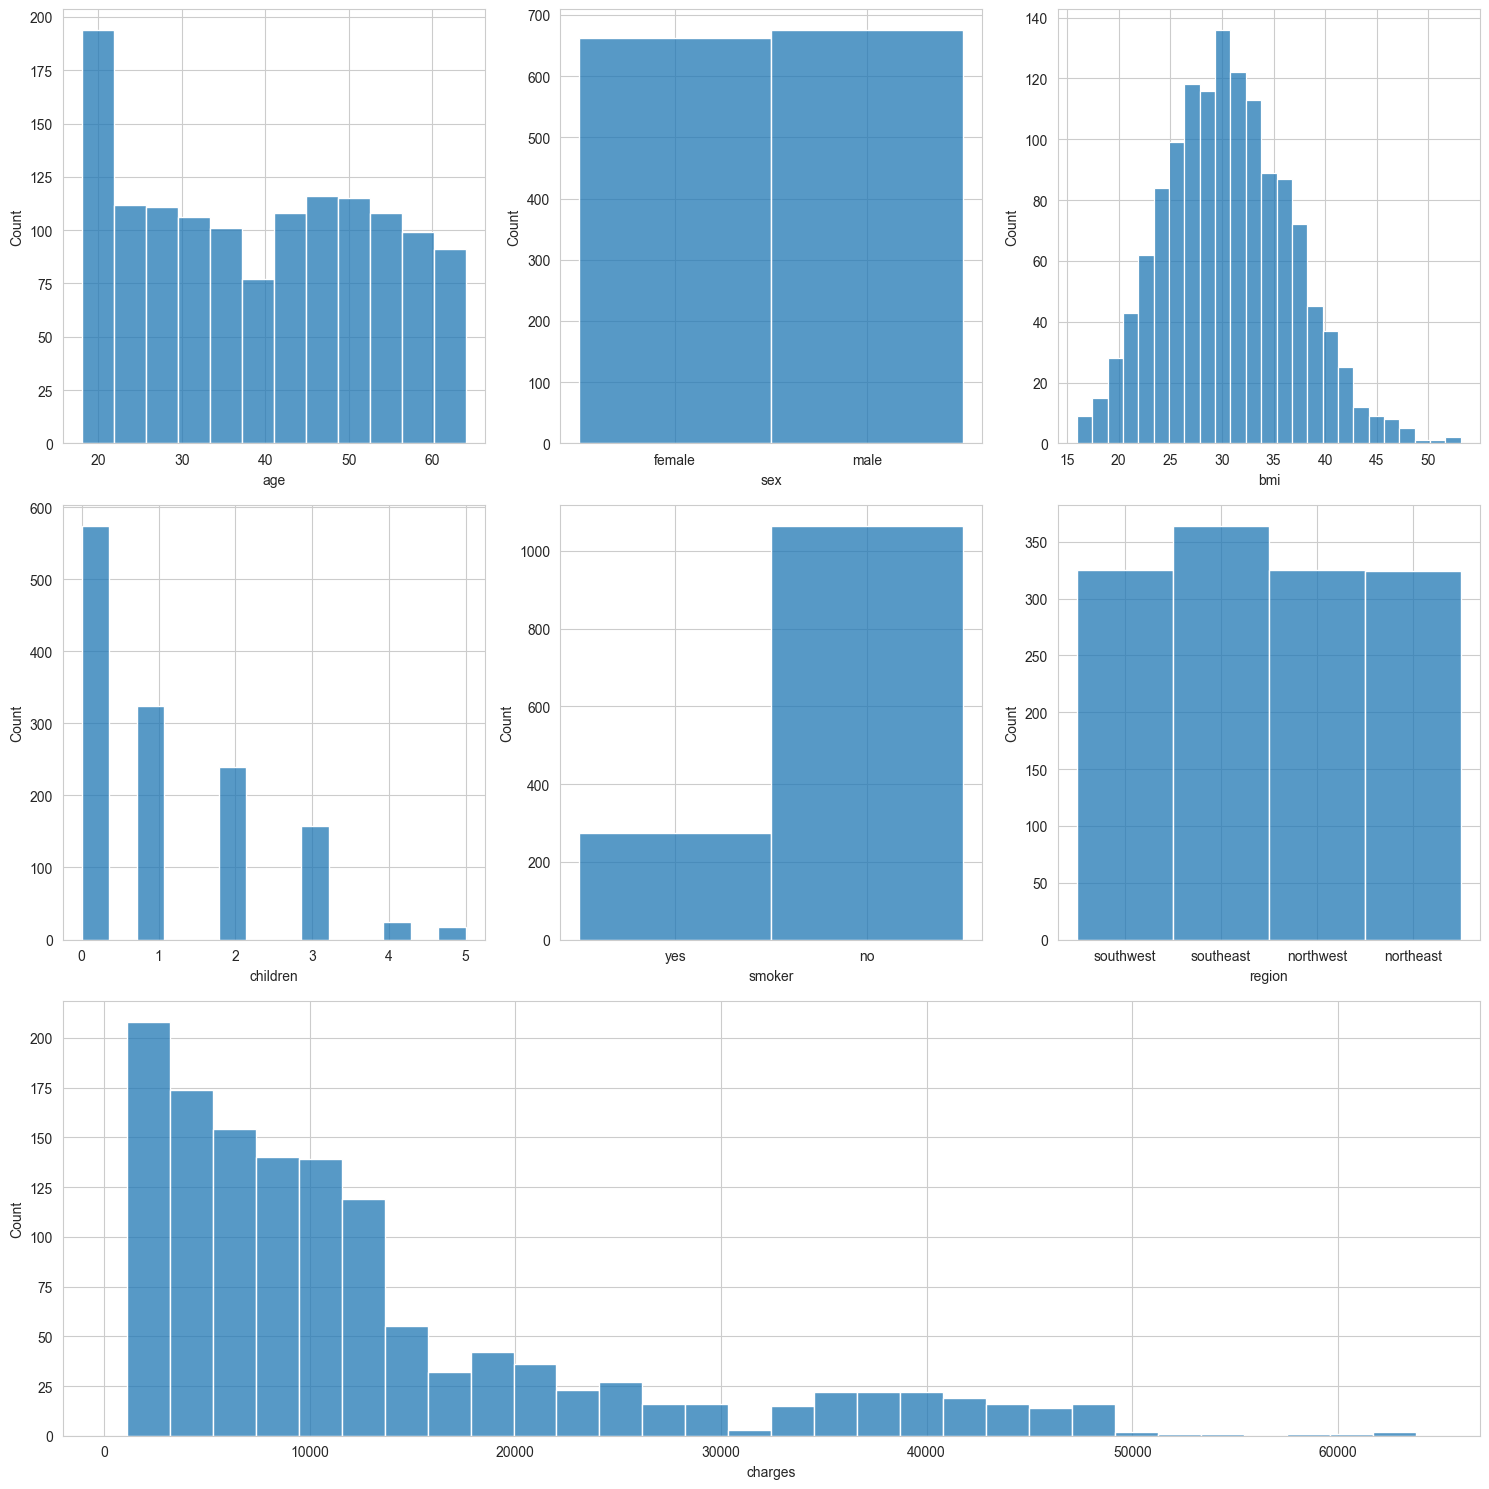

In [999]:
fig = plt.figure(figsize=(15, 15), tight_layout=True)
gs = fig.add_gridspec(3, 3)
for i in range(2):
    for j in range(3):
        sns.histplot(df[df.columns[3 * i + j]], ax=fig.add_subplot(gs[i, j]))
sns.histplot(df["charges"], ax=fig.add_subplot(gs[2, :]));

Заметим, что с возрастом стоимость страховки линейно растёт. Помимо этого, курящим страховка обходится в разы дороже. Также на графике ниже явно видно, что среди расценок присутствует три несвязанные категории: 0-13000, 13000-25000 и 30000+, однако, найти признак, по которому происходит данное разделение, вручную не удалось.

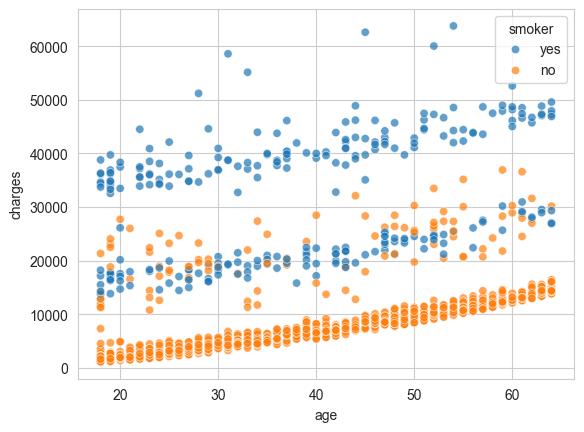

In [1000]:
sns.scatterplot(df, x="age", y="charges", hue="smoker", alpha=0.7);

Также стоит отметить, что при увеличении числа детей от 1 до 4 стоимость страховки в среднем растёт.

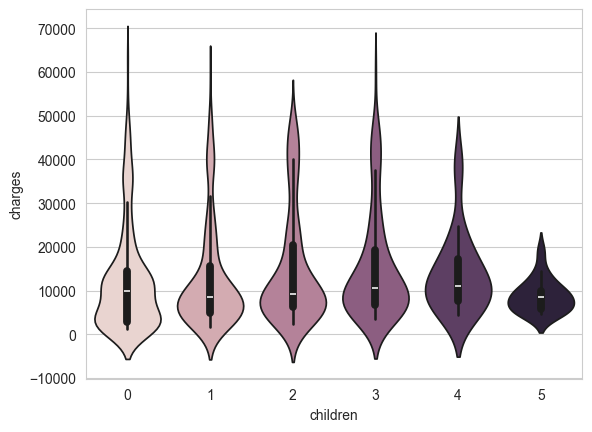

In [1001]:
sns.violinplot(df, x="children", y="charges", hue="children", legend=None);

Для других признаков подобных зависимости найти не удаётся.

Построив матрицу корреляции количественных признаков, видим, что сильной корреляции нет, но у целевой признак в некоторой степени коррелирует с индексом массы тела и возрастом (последнее мы уже отметили ранее).

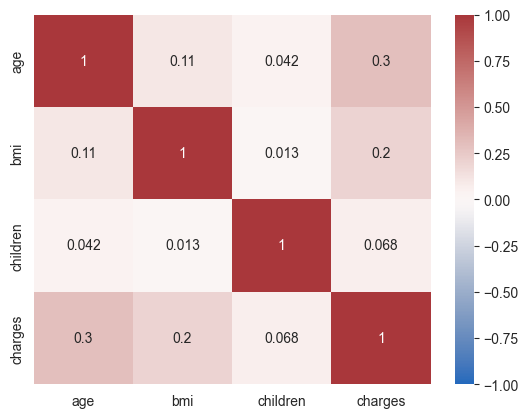

In [1002]:
df_quantitative = df.drop(columns=["sex", "smoker", "region"])
sns.heatmap(df_quantitative.corr(), vmin=-1, vmax=1, annot=True, cmap="vlag");

In [1003]:
# Далее удобнее работать с разделёнными нецелевыми и целевым признаками
X, y = df.drop(columns="charges"), df["charges"]

## Выбор наилучшего подмножества признаков

Воспользуемся RFE, чтобы отбросить потенциально ненужные признаки. В качестве "подопытной" модели возьмём Ridge из scikit-learn.

Результат ранжирования (чем меньше ранг, тем важнее признак):
1 age
1 bmi
1 children
1 region_northeast
1 region_southeast
1 region_southwest
1 smoker_no
1 smoker_yes
2 region_northwest
3 sex_male
4 sex_female


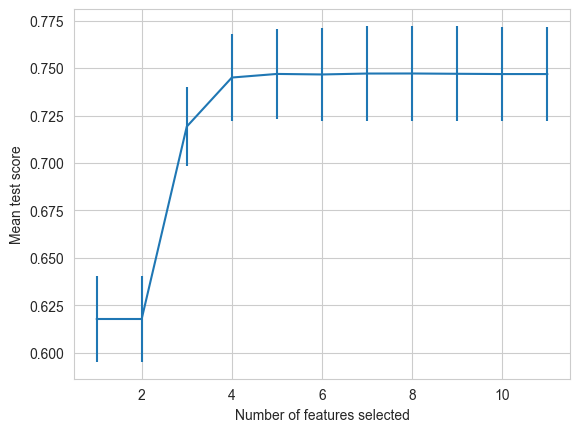

In [1004]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFECV

# One-hot кодирование -- RFE не позволяет добавить его в Pipeline
X_enc = pd.get_dummies(X)

model = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("regressor", Ridge())
    ]
)
rfecv = RFECV(
    model,
    scoring="r2",
    n_jobs=6,
    importance_getter=lambda m: m.named_steps["regressor"].coef_
)
rfecv.fit(X_enc, y)

print("Результат ранжирования (чем меньше ранг, тем важнее признак):")
for rank, feature in sorted(zip(rfecv.ranking_, X_enc.columns.values)):
    print(rank, feature)

plt.xlabel("Number of features selected")
plt.ylabel("Mean test score")
plt.errorbar(
    range(1, len(rfecv.cv_results_["mean_test_score"]) + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
);

Согласно RFE, важны все признаки, кроме пола (не важна также принадлежность к одному из регионов, но оставим её, так как это часть признака `regions`). Так как при EDA пол также особую важность не продемонстрировал, от него можно избавиться.

In [1005]:
X = X.drop(columns="sex")

## Обучение

Обучим реализованные ранее модели, а также Ridge для сравнения.

In [1006]:
pd.options.display.float_format = "{:,.2f}".format

In [1007]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder


def make_pipeline(estimator):
    transformer = make_column_transformer(
        (StandardScaler(), ["age", "bmi", "children"]),
        (OneHotEncoder(), ["smoker", "region"])
    )
    return Pipeline([("transformer", transformer), ("estimator", estimator)])

Сначала обучим модели максимально простым образом: без кросс-валидации и подбора гипер-параметров.

In [1008]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
res = []


def train_simple(estimator, estimator_name: str):
    pipeline = make_pipeline(estimator).fit(X_train, y_train)

    pred = pipeline.predict(X_train)
    mse_train = mean_squared_error(y_train, pred)
    rmse_train = mean_squared_error(y_train, pred, squared=False)
    r2_train = r2_score(y_train, pred)

    pred = pipeline.predict(X_test)
    mse_test = mean_squared_error(y_test, pred)
    rmse_test = mean_squared_error(y_test, pred, squared=False)
    r2_test = r2_score(y_test, pred)

    res.append([estimator_name, mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test])


for named_estimator in [
    (Ridge(), "Ridge"), (LinearRegressorGD(), "Full GD"), (LinearRegressorMBGD(random_state=41), "Mini-batch GD"),
    (LinearRegressorSGD(random_state=40), "Stochastic GD")
]:
    train_simple(*named_estimator)

pd.DataFrame(
    res,
    columns=["Estimator", "MSE train", "MSE test", "RMSE train", "RMSE test", "R2 train", "R2 test"]
).set_index("Estimator")

,MSE train,MSE test,RMSE train,RMSE test,R2 train,R2 test
Estimator,,,,,,
Ridge,"37,734,278.41","33,756,053.87","6,142.82","5,810.00",0.74,0.77
Full GD,"94,004,161.42","92,487,879.62","9,695.57","9,617.06",0.36,0.37
Mini-batch GD,"94,064,010.17","92,523,039.19","9,698.66","9,618.89",0.36,0.37
Stochastic GD,"94,579,965.19","92,924,090.49","9,725.22","9,639.71",0.35,0.37


Теперь обучим модели с кросс-валидацией и подбором гипер-параметров.

In [1009]:
from sklearn.model_selection import GridSearchCV


def train_via_gscv(estimator, estimator_name: str, param_grid: dict) -> pd.DataFrame:
    pipeline = make_pipeline(estimator)
    param_grid = {f"estimator__{name}": val for name, val in param_grid.items()}

    cv = GridSearchCV(
        pipeline,
        param_grid,
        scoring=["neg_mean_squared_error", "neg_root_mean_squared_error", "r2"],
        refit="neg_mean_squared_error",
        n_jobs=6,
        return_train_score=True
    )
    cv.fit(X, y)

    print(estimator_name)
    print(
        "Best params:",
        {name.removeprefix("estimator__"): val for name, val in cv.best_params_.items()}
    )
    print("Fit time with the best params:", f"{cv.refit_time_:.3f}", "sec")

    res_series = pd.DataFrame(cv.cv_results_).iloc[cv.best_index_]

    res_data = []
    res_index = []
    for scorer, metric, negator in [
        ("neg_mean_squared_error", "MSE", -1),
        ("neg_root_mean_squared_error", "RMSE", -1),
        ("r2", "R2", 1)
    ]:
        for train_test in ["train", "test"]:
            row = []
            for i in range(5):  # 5 folds
                row.append(res_series[f"split{i}_{train_test}_{scorer}"] * negator)
            row.append(res_series[f"mean_{train_test}_{scorer}"] * negator)
            row.append(res_series[f"std_{train_test}_{scorer}"])
            res_data.append(row)
            res_index.append(f"{metric} {train_test}")
    return pd.DataFrame(
        data=res_data,
        index=res_index,
        columns=[*(f"Fold {i}" for i in range(1, 6)), "Mean", "STD"]
    )


In [1010]:
train_via_gscv(
    Ridge(), "Ridge",
    {"alpha": [0.01, 0.1, 1, 2]}
)

Ridge
Best params: {'alpha': 1}
Fit time with the best params: 0.004 sec


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean,STD
MSE train,"36,435,113.13","36,174,026.29","37,582,927.78","35,747,053.63","36,397,222.25","36,467,268.62","609,152.94"
MSE test,"36,985,102.04","38,082,567.48","32,518,600.21","39,656,337.86","37,095,275.28","36,867,576.57","2,376,242.70"
RMSE train,"6,036.15","6,014.48","6,130.49","5,978.88","6,033.01","6,038.60",50.26
RMSE test,"6,081.54","6,171.11","5,702.51","6,297.33","6,090.59","6,068.61",198.75
R2 train,0.75,0.76,0.74,0.76,0.75,0.75,0.01
R2 test,0.76,0.71,0.78,0.73,0.76,0.75,0.02


In [1011]:
train_via_gscv(
    LinearRegressorGD(), "Full GD",
    {
        "alpha": [0.01, 0.1, 1, 2],
        "tol": [1e-5, 1e-4, 1e-3],
        "eta0": [0.1, 1, 10],
    }
)

Full GD
Best params: {'alpha': 0.01, 'eta0': 10, 'tol': 1e-05}
Fit time with the best params: 0.221 sec


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean,STD
MSE train,"36,532,413.33","36,268,120.25","37,671,815.47","35,844,350.90","36,490,909.18","36,561,521.82","606,465.84"
MSE test,"37,001,891.64","37,833,369.65","33,037,937.55","39,471,694.54","37,391,343.11","36,947,247.30","2,127,954.72"
RMSE train,"6,044.20","6,022.30","6,137.74","5,987.02","6,040.77","6,046.41",49.97
RMSE test,"6,082.92","6,150.88","5,747.86","6,282.65","6,114.85","6,075.83",177.51
R2 train,0.75,0.76,0.74,0.75,0.75,0.75,0.01
R2 test,0.76,0.71,0.77,0.73,0.75,0.75,0.02


In [1018]:
train_via_gscv(
    LinearRegressorMBGD(random_state=41), "Mini-batch GD",
    {
        "alpha": [0.01, 0.1, 1, 2],
        "tol": [1e-5, 1e-4, 1e-3],
        "eta0": [0.1, 1, 10],
        "batch_size": [0.001, 0.1]
    }
)

Mini-batch GD
Best params: {'alpha': 0.01, 'batch_size': 0.1, 'eta0': 1, 'tol': 1e-05}
Fit time with the best params: 0.050 sec


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean,STD
MSE train,"36,657,375.14","36,339,264.97","37,753,917.07","35,954,248.63","36,561,613.53","36,653,283.87","601,177.47"
MSE test,"36,968,071.73","37,807,154.25","33,254,779.50","39,407,567.59","37,638,282.42","37,015,171.10","2,043,615.88"
RMSE train,"6,054.53","6,028.21","6,144.42","5,996.19","6,046.62","6,053.99",49.47
RMSE test,"6,080.14","6,148.75","5,766.70","6,277.54","6,135.00","6,081.63",170.25
R2 train,0.75,0.76,0.74,0.75,0.75,0.75,0.01
R2 test,0.76,0.71,0.77,0.73,0.75,0.75,0.02


In [1020]:
# Стохастический градиентный спуск без увеличения максимального числа итераций (1000 итераций)
train_via_gscv(
    LinearRegressorSGD(random_state=40), "Stochastic GD",
    {
        "alpha": [0.01, 0.1, 1, 2],
        "tol": [1e-5, 1e-4, 1e-3],
        "eta0": [0.1, 1, 10],
    }
)

Stochastic GD
Best params: {'alpha': 1, 'eta0': 1, 'tol': 1e-05}
Fit time with the best params: 0.042 sec


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean,STD
MSE train,"94,540,490.32","96,792,987.65","92,138,772.00","89,843,549.89","90,163,656.36","92,695,891.24","2,647,534.37"
MSE test,"101,126,561.08","82,834,308.55","94,522,259.08","89,358,867.84","96,636,040.72","92,895,607.45","6,294,818.45"
RMSE train,"9,723.19","9,838.34","9,598.89","9,478.58","9,495.45","9,626.89",137.14
RMSE test,"10,056.17","9,101.34","9,722.26","9,452.98","9,830.36","9,632.62",328.96
R2 train,0.34,0.36,0.37,0.38,0.38,0.37,0.01
R2 test,0.35,0.36,0.36,0.40,0.36,0.37,0.02


In [1021]:
# Стохастический градиентный спуск с увеличением максимального числа итераций в 10 раз
train_via_gscv(
    LinearRegressorSGD(max_iter=10000, random_state=40), "Stochastic GD",
    {
        "alpha": [0.01, 0.1, 1, 2],
        "tol": [1e-5, 1e-4, 1e-3],
        "eta0": [0.1, 1, 10],
    }
)

Stochastic GD
Best params: {'alpha': 0.1, 'eta0': 1, 'tol': 1e-05}
Fit time with the best params: 0.406 sec


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean,STD
MSE train,"42,349,495.68","43,149,140.49","45,721,128.53","55,416,382.35","50,435,530.02","47,414,335.41","4,896,362.14"
MSE test,"43,019,547.96","41,728,485.85","44,142,681.76","57,129,404.65","54,606,829.79","48,125,390.00","6,417,683.57"
RMSE train,"6,507.65","6,568.80","6,761.74","7,444.22","7,101.80","6,876.84",351.27
RMSE test,"6,558.93","6,459.76","6,644.00","7,558.40","7,389.64","6,922.15",457.49
R2 train,0.71,0.71,0.69,0.62,0.65,0.68,0.03
R2 test,0.72,0.68,0.70,0.62,0.64,0.67,0.04


### Выводы

Подведём итоги, исходя из представленных выше результатов:

1. Без кросс-валидации и подбора гипер-параметров реализованные модели показали себя в разы хуже (у всех $R^2 = 0.37$ для тестовых данных), чем после них (полный и mini-batch градиентные спуски достигли $R^2 = 0.75$). Из этого следует, что значения гипер-параметров по умолчанию не подходят для выбранного датасета.
2. Модель с полным градиентным спуском достигла результатов, аналогичных встроенной в scikit-learn Ridge, что свидетельствует о правильности реализации.
3. Mini-batch градиентный спуск показал себя не хуже полного (разница находится на уровне стандартного отклонения), а работает при этом в разы быстрее (обучение в 4 раза быстрее при размере батча, равном 10% объёма данных). Для данного датасета наилучшим решением выглядит использовать именно его (если не считать, что Ridge работает ещё быстрее).
4. Стохастический градиентный спуск показал себя хуже остальных ($R^2$ меньше в два раза, RMSE выше в 1.5 раза), при этом работает он не сильно быстрее mini-batch градиентного спуска (обучение лучших моделей продлилось у них 42 и 50 миллисекунд соответственно). При этом увеличение максимального числа итераций позволяет улучшить результаты, но затрачиваемое время начинает превосходить время, необходимое остальным моделям.